# PHY4268 Tutorial 2 - Qiskit Qubit Hamiltonian

1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
       
May 2024

$
\newcommand{\HH}{\mathtt{H}}  
\newcommand{\ad}{a^\dagger}  
\newcommand{\kb}[2]{|#1\rangle\langle#2|} 
\newcommand{\proj}[1]{|#1\rangle\langle#1|}
\newcommand{\bk}[2]{\langle#1|#2\rangle}
\newcommand{\ket}[1]{|#1\rangle}
$

L'objectif de ce **tutoriel 2** est de présenter brièvement comment on établi une correspondance entre les opérateurs d'échelle fermioniques (Hamiltonien en seconde quantification ou Hanmiltonien fermionique)et les opérateurs de Pauli (Hamiltonien Qubit), à travers les transformations de Jordan-Wigner (JWT), de parité (PT) ou de Bravyi-Kitaev (BKT) (voir les parties marquées en rouge sur la Figure 1 présentant la VQE). De façon spécifique, à la fin de ce tutoriel, l'apprenant doit
* avoir compris le principe de l'encodage d'un problème de structure électronique en seconde quantification sur un calculateur quantique;
* être capable d'utiliser le framework qiskit-nature
    * obtenir l'Hamiltonien en 1ère quantification (avec PySCFDriver);
    * transformer celui-ci en Hamiltonien en seconde quantification (ou Hamiltonien fermionique);
    * transformer un Hamiltonien fermionique en Hamiltonien Qubit.

## Qiskit-nature

Ce tutoriel utilise essentiellement le package Qiskit Nature dont la conception abstraite est donnée par la figure ci-dessous.

![Qiskit_Nature_overview](Graphics/Qiskit_Nature_overview.png)

Le package se divise en deux concepts avec chacun trois piliers chacun :

* les `problems`,  qui sont des représentations de problèmes scientifiques auxquels on cherche une solution;
    * _Electronic Structure Problem_ représentant le problème de l'équation de Schrödinger électronique des systèmes moléculaires;

    * _Vibrational Structure Problem_ représentant le problème posé par l'Hamiltonien de Watson des systèmes moléculaires;

    * _Lattice Model Problem_ représentant les problèmes définis sur des treillis ou systèmes périodiques;

* les `algorithms`, qui fournissent les moyens de trouver des solutions auxdits problèmes;

    * _Ground State Solver_ pour trouver l'état fondamental d'un problème;

    * _Excited States Solver_ pour trouver les états excités d'un problème;

    * _Hamiltonian Simulation_ pour simuler la dynamique d'un problème (pas encore implémenté).
    
### Articulation des modules de Qiskit Nature

La bibliothèque Qiskit Nature comprend différents modules s'articulant autour de :

1. chargement de données à partir de pilotes (drivers) de chimie quantique (PySCF, Psi4, Gaussian, etc.) ou de formats de fichiers;
2. construction et manipulation d'opérateurs de seconde quantification;
3. traduction de la seconde quantification à l'espace qubit;
4. une bibliothèque de circuits quantiques (*ansatz*) d'analyses ciblées en sciences naturelles;
5. algorithmes et utilitaires spécifiques aux sciences naturelles ppour faciliter l'utilisation des  algorithmes de `Qiskit Algorithms`;
- et beaucoup plus.

Le flowchart suivant résume ces différentes étapes, qui permettent, avec Qiskit Nature, de traduire, de partir de la structure géométrique d'une molécule à l'Hamiltonien qubit.

![Qiskit-nature flowchart](./Graphics/Qiskit_nature_Flow.png)

1. les pilotes (drivers) de chimie quantique, lorsqu'ils sont fournis avec une configuration moléculaire, produisent `ElectronicStructureProblem` qui rassemble toutes les informations sur les problèmes requises par Qiskit Nature (intégrales à 1 ($h_{pq}$) et 2 ($h_{pqrs}$) corps dans la base orbitale électronique choisie, ainsi que d'autres données).

2. Qiskit Nature convertit l'`ElectronicStructureProblem` en des `FermionicOperator` (Hamiltonien fermionique). 

3. Ces `fermionicOperator` sont par la suite mappés sur des opérateurs qubit (Hamiltionien qubit) avec un `QubitMapper`, par ex. par une transformation de **Jordan Wigner**.

4. L'Hamiltonien qubit est alors prêt pour le calcul quantique (Algorithme quantique).


### Installation 

> pip install qiskit-nature[pyscf] -U


In [1]:
try:
    import qiskit_nature
except:
    !pip install qiskit-nature[pyscf] -U
    import qiskit_nature
    
qiskit_nature.__version__

'0.7.2'

### Electronic Structure Problem

Dans ce qui suit, nous utilisons le driver PySCF, pour construction d'un opérateur Hamiltonien fermionique de la molécule d'hydrogène à la longueur de la liaison d'équilibre ($0,735\mathring{A}$)  à l'état singulet et sans charge.
![Hydrogen molecule](Graphics/h2.png)


In [ ]:
from qiskit_nature.units import DistanceUnit # Pour la gestion des unités de distance
from qiskit_nature.second_q.drivers import PySCFDriver # 

H2_xyz = "H 0 0 0; H 0 0 0.735"
H2_driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735", #Coordonnées xyz H2
    basis='3-21G', #'def2-SVP', # Ensemble de base
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

In [29]:
# For 3D plotting
try :
    import py3Dmol
except:
    !pip install py3Dmol
    import py3Dmol
py3Dmol.__version__

'2.1.0'

In [35]:
H2_driver.atom

'H 0 0 0; H 0 0 0.735'

In [36]:
# 3D representation with py3Dmol
xyz_view = py3Dmol.view(width=300,height=300)
xyz_view.addModel(H2_driver.atom(format="xyz"),'xyz')
xyz_view.setStyle({'stick': {}, 'sphere': {'scale': .30}})
xyz_view.zoomTo()
xyz_view.show()

TypeError: 'str' object is not callable

In [2]:
H2_problem = H2_driver.run() # Electronic Structure Problem

#### Extraction de quelques propriétés

In [3]:
H2_problem.reference_energy

-1.1229598124021147

In [4]:
H2_problem.nuclear_repulsion_energy

0.7199689944489797

In [5]:
print(f"Hydrogen molecule, basis: {H2_driver.basis}, Hartree-Fock calculation")
print(f"Number of alpha electrons: {H2_problem.num_alpha}")
print(f"Number of beta electrons: {H2_problem.num_beta}")
print(f"Number of spin orbitals: {H2_problem.num_spin_orbitals}")
print(f"pin orbitals occupation: {H2_problem.orbital_occupations}")
print(f"Spin orbitals energies: {H2_problem.orbital_energies}")

Hydrogen molecule, basis: 3-21G, Hartree-Fock calculation
Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 8
pin orbitals occupation: [1. 0. 0. 0.]
Spin orbitals energies: [-0.59418669  0.26564978  0.91760423  1.53171381]


### Hamiltonien fermionique de H2

In [6]:
H2_hamiltonian = H2_problem.hamiltonian # Hamiltonien en 1ere quantification
H2_fermionic_op = H2_hamiltonian.second_q_op() # Hamiltonien fermionique

In [7]:
print(H2_fermionic_op)

Fermionic Operator
number spin orbitals=8, number terms=528
  -1.2487422554432468 * ( +_0 -_0 )
+ -0.16735956952108932 * ( +_0 -_2 )
+ -0.5567540613297292 * ( +_1 -_1 )
+ -0.2070778905623435 * ( +_1 -_3 )
+ -0.16735956952108932 * ( +_2 -_0 )
+ -0.0907045428965826 * ( +_2 -_2 )
+ -0.20707789056234369 * ( +_3 -_1 )
+ 0.3244016873074645 * ( +_3 -_3 )
+ -1.2487422554432468 * ( +_4 -_4 )
+ -0.16735956952108932 * ( +_4 -_6 )
+ -0.5567540613297292 * ( +_5 -_5 )
+ -0.2070778905623435 * ( +_5 -_7 )
+ -0.16735956952108932 * ( +_6 -_4 )
+ -0.0907045428965826 * ( +_6 -_6 )
+ -0.20707789056234369 * ( +_7 -_5 )
+ 0.3244016873074645 * ( +_7 -_7 )
+ 0.3272778520176996 * ( +_0 +_0 -_0 -_0 )
+ 0.08367974023919297 * ( +_0 +_0 -_2 -_0 )
+ 0.22771178000942116 * ( +_0 +_1 -_1 -_0 )
+ 0.07177423650389197 * ( +_0 +_1 -_3 -_0 )
+ 0.08367974023919297 * ( +_0 +_2 -_0 -_0 )
+ 0.2807371312277755 * ( +_0 +_2 -_2 -_0 )
+ 0.07177423650389197 * ( +_0 +_3 -_1 -_0 )
+ 0.33476307215274764 * ( +_0 +_3 -_3 -_0 )
+ 0.327277

On note qu'avec l'ensemble de base `3-21G`, on a 8 spin-orbitales et 528 termes. Le premier terme a pour opérateur fermionique $\ad_0a_0$ et le 4e, $\ad_0a_{10}$

In [8]:
H2_particle_number_op = H2_problem.properties.particle_number.second_q_ops()["ParticleNumber"]
print(H2_particle_number_op)

Fermionic Operator
number spin orbitals=8, number terms=8
  1.0 * ( +_0 -_0 )
+ 1.0 * ( +_1 -_1 )
+ 1.0 * ( +_2 -_2 )
+ 1.0 * ( +_3 -_3 )
+ 1.0 * ( +_4 -_4 )
+ 1.0 * ( +_5 -_5 )
+ 1.0 * ( +_6 -_6 )
+ 1.0 * ( +_7 -_7 )


## Correspondance (mapping) fermion qubit

En simulation quantique, encoder un problème de structure électronique en seconde quantification sur un calculateur quantique revient à établir une correspondance entre les opérateurs d'échelle fermioniques et les opérateurs de Pauli. Les transformations de Jordan-Wigner (JWT), de Partité (PT) et de Bravyi-Kitaev (BKT) sont parmis les plus utilisés en calculs quantiques. Pour plus de détails, consulter J. T. Seeley, M. J. Richard, and P. J. Love,*The Bravyi-Kitaev transformation for quantum computation of electronic structure*, J. Chem. Phys **137**, 224109 (2012).

### Décomposition de Pauli

Comme $\{\mathbb{I}, \mathtt{X}, \mathtt{Y}, \mathtt{Z}\}$ forme une base complète pour tout opérateur Hermitien 1- ou multi-qubit, l'ingrédient clé des algorithmes variationnels est de décomposer l'Hamiltonien électronique en termes de produits des matrices de Pauli,
\begin{equation}
\mathtt{P}_j=\mathtt{X}_{M-1}^j\otimes\mathtt{X}_{M-2}^j\otimes\mathtt{X}_k^j\otimes\dots\mathtt{X}_0^j
=\left(\bigotimes_i^{M-1}\mathtt{X}_i^j\right),
\end{equation}
où les opérateurs de Pauli $\mathtt{X}^j\in\{\mathbb{I},\mathtt{X},\mathtt{Y},\mathtt{Z}\}$ sont tels que
\begin{equation}
\begin{aligned}
    &\mathtt{X}^i\mathtt{X}^j=\mathbb{I}\delta_{ij}+i\varepsilon_{ijk}\mathtt{X}^k, \\
    &\varepsilon_{ijk}=\begin{cases}+1, & \text{ pour les permutations circulaires droites de } (i,j,k) \\
    -1, & \text{ pour les permutations circulaires gauches de }(i,j,k) \\
    0, & \text{ sinon} \end{cases}
\end{aligned}
\end{equation}

\begin{align}
&\mathtt{X}:=\kb{0}{1}+\kb{1}{0}, &\mathtt{Y}&:=i(-\kb{0}{1}+\kb{1}{0}), &\mathtt{Z}:=\proj{0}-\proj{1}.
\end{align}
Les opérateurs de Pauli sont à la fois unitaires et Hermitiens.

L'Hamiltonien total peut alors être représenté comme la combinaison linéaire de $\mathtt{P}_j$,
\begin{align*}
&\mathtt{H}=\sum_j^{N_k}w_j\mathtt{P}_j=\sum_j^{N_k}w_j\left(\bigotimes_i^{M-1}\mathtt{X}_i^j\right),
&w_j=\langle\mathtt{H},\mathtt{P}_j\rangle=\rm{Tr}(\mathtt{H}^\dagger\mathtt{P}_j),
\end{align*}
où $w_j$ sont les poids de la chaîne de Pauli $\mathtt{P}_j$, i indique sur quel qubit l'opérateur agit, et j désigne le terme dans l'Hamiltonien.

Pour un Hamiltonien de la 2e quantification, le nombre total de chaînes de Pauli $N_k$ dépend du nombre de termes $h_{pq}$ à 1-électron et $h_{pqrs}$ à 2-électrons.


### Opérateurs d'échelle qubit

Ce sont les opérateurs suivants qui agissent localement sur les qubits :
$$
\begin{array}{l|l}
\textbf{Opérateur qubit}             &  \textbf{Description}\\\hline
\mathbb{I}=\begin{pmatrix}1 & 0 \\ 0 &1 \end{pmatrix} &\text{Identité}\\
\mathtt{Q}^-=\begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix}=\frac12(\mathtt{X} + i\mathtt{Y}) =\kb{1}{0} & \text{Annihilation} \\
\mathtt{Q}^+=\begin{pmatrix}0 & 0 \\ 1 & 0 \end{pmatrix}=\frac12(\mathtt{X} - i\mathtt{Y}) =\kb{0}{1} & \text{Création}\\
\mathtt{Q}^+\mathtt{Q}^-=\begin{pmatrix}0 & 0 \\ 0 &1 \end{pmatrix}=\frac12(\mathbb{I} - \mathtt{Z}) =\proj{1} & \text{Un nombre (particule)}\\
\mathtt{Q}^-\mathtt{Q}^+=\begin{pmatrix}0 & 0 \\ 0 &1 \end{pmatrix}=\frac12(\mathbb{I} + \mathtt{Z}) =\proj{0} & \text{Zéro nombre (trou)}\\\hline
\end{array}
$$
Les opérateurs qubits sont antisymétrique: $\{\mathtt{Q}^+,\mathtt{Q}^-\}=\mathtt{Q}^+\mathtt{Q}^- + \mathtt{Q}^-\mathtt{Q}^+ = \mathbb{I}$.

## Transformation de Jordan-Wigner (JWT)

![Jordan Mapping](Graphics/jw_mapping.png)

Elle stocke l'occupation de chaque spin-orbite dans chaque qubit, i.e.,
\begin{align}
&\ket{f_{M-1},\dots,f_k,\dots, f_1,f_0} \rightarrow \ket{q_{M-1},
\dots,q_k,\dots, q_1, q_0}, 
&q_k :=\{\uparrow,\downarrow\}\equiv f_k \in \{0, 1 \}.
\end{align}
et les opérateurs fermioniques de création et d'annihilation (respectivement
$\ad_k$ et $a_k$) sur des opérateurs de qubits non locaux de la forme
\begin{align}
\begin{aligned}
&\ad_k \mapsto \frac12(\mathtt{X}_k - i\mathtt{Y}_k)\otimes \mathtt{Z}_{k-1} \otimes \dots \otimes \mathtt{Z}_0
\equiv \mathtt{Q}^+_k \bigotimes_{k=p-1}^0\mathtt{Z}_k,
&a_k \mapsto \frac12(\mathtt{X}_k + i \mathtt{Y}_k)\otimes\mathtt{Z}_{k-1}\otimes \dots \otimes \mathtt{Z}_0 
\equiv \mathtt{Q}_k^- \bigotimes_{k=p-1}^0\mathtt{Z}_k.
\end{aligned}
\end{align}


Par exemple, puisque $\mathtt{Z}_k^2=\mathbb{I}_k$, on a
\begin{array}{l|l}
\textbf{Fermion}  & \textbf{Qubit}  \\\hline
a\ket{0001}+b\ket{0010}+c\ket{0100}+d\ket{1000} & a\ket{0001}+b\ket{0010}+c\ket{0100}+d\ket{1000} \\
a_0,\quad  a_1,\quad  a_2,\quad a_3 &\mathtt{Q}^-_0,\quad \mathtt{Q}^-_1\mathtt{Z}_0,\quad \mathtt{Q}^-_2\mathtt{Z}_1 \mathtt{Z}_0,\quad \mathtt{Q}^-_3\mathtt{Z}_2 \mathtt{Z}_1 \mathtt{Z}_0 \\
\ad_0,\quad \ad_1,\quad \ad_2,\quad \ad_3 & \mathtt{Q}^+_0,\quad \mathtt{Q}^+_1\mathtt{Z}_0,\quad \mathtt{Q}^+_2\mathtt{Z}_1 \mathtt{Z}_0,\quad \mathtt{Q}^+_3\mathtt{Z}_2 \mathtt{Z}_1 \mathtt{Z}_0 \\
n_k = \ad_k a_k &\mathtt{Q}^+_k \mathtt{Q}^-_k = \proj{1}_k=\frac12(\mathbb{I} - \mathtt{Z})_k \\\hline
\end{array}


### Construction des Hamiltoniens dans la représentation de Jordan-Wigner

Pour traduire l'Hamiltonien en une somme d'opérateurs de Pauli, il suffit de remplacer chacun des opérateurs $\ad$ et $a$ dans l'Hamiltonien fermionique par les chaînes d'opérateurs de Pauli correspondante. 

#### Operateurs 1-corps $\ad_p a_q $

* Quand $p=q$, tous les opérateurs $\mathtt{Z}$ disparaissent compte tenu du fait que $\mathtt{Z}_p^2 = \mathbb{I}_p$, et on a 
  $$ \ad_p a_p \mapsto \mathtt{Q}^+_p \left(\bigotimes_{k=p-1}^0\mathtt{Z}_k\right)
  \mathtt{Q}^-_p \left(\bigotimes_{k=p-1}^0 \mathtt{Z}_k\right) = \frac12(\mathbb{I}_p-\mathtt{Z}_p).$$

* Pour tous les indices $p\neq q$, les opérateurs $\mathtt{Z}$ demeurent pour qubits entre $p$ et $q$, y compris p si $p < q$ et on a,
 
 \begin{align*} 
  \ad_p a_q \mapsto & \mathtt{Q}^+_p \left(\bigotimes_{k=p-1}^0\mathtt{Z}_k\right)
  \mathtt{Q}^-_q \left(\bigotimes_{k=q-1}^0 \mathtt{Z}_k\right)
  =\frac14(\mathtt{X}_p - i\mathtt{Y}_p)(\mathtt{X}_q + i\mathtt{Y}_q) \left(\bigotimes_{k=q-1}^p\mathtt{Z}_k\right)\\
  &=\frac14 (\mathtt{X}_p\mathtt{X}_q + i\mathtt{X}_p\mathtt{Y}_q
 - i\mathtt{Y}_p\mathtt{X}_q + \mathtt{Y}_p\mathtt{Y}_q ) \left(\bigotimes_{k=q-1}^p\mathtt{Z}_k\right)
\end{align*}

Par suite, dans les intégrales à 1-corps, on a les deux classes suivantes avec des orbitales à valeurs réelles, pour $p\leq q$ (ordre normal),

$$
\begin{array}{l|l|l}
\textbf{Opérateur} & \textbf{Seconde Quantification} &  \textbf{Représentation de Pauli} \\\hline
\text{Nombre} & \HH_{pp}=h_{pp}\ad_p a_p& \frac{h_{pp}}{2}(\mathbb{I}_p-\mathtt{Z}_p)\\
\text{Excitation}&\HH_{pq}=h_{pq}\ad_p a_q + h_{qp}  \ad_q a_p &\frac{h_{pq}}{2}(\mathtt{X}_q\mathtt{X}_p+\mathtt{Y}_q\mathtt{Y}_p)\left(\bigotimes_{k=q-1}^p\mathtt{Z}_k\right)\\\hline
\end{array}
$$


### Exemple avec Qiskit nature 

In [9]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp

Définissons une fonction `label_to_qubit()` pour convertir les opérateurs fermioniques en opérateurs qubits.

In [10]:
def label_to_qubit(label, mapper):
    """
    Conversion les opérateurs fermioniques en opérateurs qubits
    
    Args:
        label(dict): opérateur fermionique avec son coefficient
        mapper (Mapper): Qubit mapper
    
    Return:
        qubit_op (SparsePauliOp): opérateurs fermioniques avec les coefficients
    """
    
    f_op = FermionicOp(label)
    qubit_op = mapper.map(f_op)
    
    return qubit_op

Convertissons les opérateurs fermioniques {"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}, qui représentent respectivement $\ad_0,\ \ad_1,\ \ad_3$, en opérateurs qubits avec la JWT:

In [11]:
for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}):
  qubit_op = label_to_qubit(k, JordanWignerMapper())
  print(f"{k}:\n {qubit_op}\n")

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZZ', 'YZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZZZ', 'YZZZ'],
              coeffs=[0.5+0.j , 0. -0.5j])



### Hamiltonien qubit de H2

In [12]:
H2_qubit_JW_op = JordanWignerMapper().map(H2_fermionic_op)

print("Number of items in the JWT Pauli list:", len(H2_qubit_JW_op))
# print(H2_qubit_JW_op)

Number of items in the JWT Pauli list: 185


In [13]:
H2_qubit_JW_op.num_qubits

8

In [40]:
from qiskit_nature.second_q.circuit.library import HartreeFock


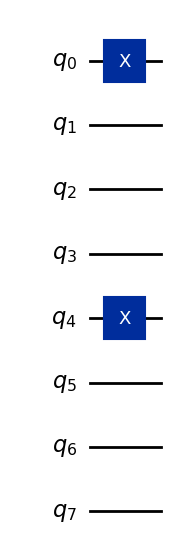

In [48]:
hf_state = HartreeFock(H2_problem.num_spatial_orbitals, H2_problem.num_particles, JordanWignerMapper())
hf_state.draw("mpl")

## Transformation de parité

C'est la transformation dual de la JWT: les opérateurs de la parité sont légers alors que les opérateurs d'occupation sont lourds. Le calcul des parités peut être réalisé en utilisant uniquement des opérateurs $\mathtt{X}$ à 1-qubit et en utilisant la transformation de parité suivante,
\begin{align}
&\ket{f_{M-1},\dots,f_k,\dots, f_1,f_0} \mapsto \ket{\mathbf{p}} , \qquad p_k = \sum_{j=k}^0 q_j \pmod 2 = q_k\oplus\dots\oplus q_0\\
& \ad_k \mapsto \mathtt{X}_{M-1} \otimes \dots \otimes \mathtt{X}_{k+1} \otimes
\frac12(\mathtt{X}_k\otimes \mathtt{Z}_{k-1} - i \mathtt{Y}_k)\equiv \mathtt{X}_{M-1} \otimes \dots \otimes \mathtt{X}_{k+1} \otimes \mathtt{P}_k^+,\\
& a_k \mapsto \mathtt{X}_{M-1} \otimes \dots \otimes \mathtt{X}_{k+1} \otimes
\frac12(\mathtt{X}_k\otimes \mathtt{Z}_{k-1} + i \mathtt{Y}_k)\equiv \mathtt{X}_{M-1} \otimes \dots \otimes \mathtt{X}_{k+1} \otimes \mathtt{P}_k^-,\\
&\mathtt{P}_k^\pm =Q^\pm_k \otimes \proj{0}_{k-1} - Q^\mp_k \otimes \proj{1}_{k-1} .
\end{align}

Afin de définir les transformations entre les bases, nous considérerons en termes de correspondance entre chaînes de bits. Pour
toutes les transformations que nous considérons, qui ne font intervenir que des sommes de bits $\mod 2$, il est possible de représenter leur action par matrices agissant sur le vecteur de valeurs binaires correspondant à un état de base logique donné. La correspondance à la base de parité est donnée par :
$$ p_k = \sum_j [ \pi_n]_{kj}\ f_j,$$
où $n$ est le nombre d'orbitales. $\pi_n$ est la matrice $(n\times n)$ suivant
\begin{align}
 & [\pi_n]_{kj} =  
  \begin{cases}
    1 & \quad k < j \\
    0 & \quad k \geq j\\
  \end{cases} ,
  &  \pi_n = 
 \begin{pmatrix}
  1 & 1 & \cdots & 1 \\
  0 & 1 & \cdots & 1 \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  0 & 0 & \cdots & 1
 \end{pmatrix}
\end{align}
Soulignons que nous indexons la matrice $\pi_n$ à partir du coin inférieur droit, par souci de cohérence avec notre schéma de numérotation orbitale. 

Par exemple, pour changer l'état de base du numéro d'occupation $|1 0 1 0 0 1 1 1\rangle$ en son état de base de parité correspondant $|1 0 0 1 1 1 0 1\rangle$, nous agissons avec la matrice $\pi_8$ sur la chaîne de bits appropriée :

$$
\begin{matrix}
& \begin{matrix}f_7 & f_6 & f_5 & f_4 & f_3 & f_2 & f_1 & f_0 \end{matrix} \\
\begin{matrix}p_7\\p_6\\p_5\\p_4\\p_3\\p_2\\p_1\\p_0\end{matrix}&
\begin{pmatrix} 1_{\phantom{7}} & 1_{\phantom{6}} & 1_{\phantom{5}} & 1_{\phantom{4}} & 1_{\phantom{3}} & 1_{\phantom{2}} & 1_{\phantom{1}} & 1_{\phantom{0}} \\
               0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
               0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\
               0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 \\
               0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
               0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 \\
               0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
               0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
 \end{pmatrix}
\end{matrix}
\begin{pmatrix}
  1 \\
  0 \\
  1 \\
  0 \\
  0 \\
  1 \\
  1 \\
  1\\
 \end{pmatrix}
 =
 \begin{pmatrix}
  1 \\
  0 \\
  0 \\
  1 \\
  1 \\
  1 \\
  0 \\
  1\\
 \end{pmatrix}
$$

Le tableau suivant donne quelques exemples de la transformation de parité.
$$
\begin{array}{l|l}
\textbf{Fermion} & \textbf{Qubit} \\ \hline
a\ket{0001}+b\ket{0010}+c\ket{0100}+d\ket{1000} & a\ket{1111}+b\ket{1110}+c\ket{1100}+d\ket{1000}  \\
a_0 ,\quad a_1 ,\quad a_2 ,\quad a_3 &
\begin{split}
&\mathtt{X}_3\mathtt{X}_2\mathtt{X}_1Q^-_0 ,\quad \mathtt{X}_3\mathtt{X}_2\big( Q^-_1\proj{0}_0 - Q^+_1\proj{1}_0 \big) ,\\ &\mathtt{X}_3\big( Q^-_2\proj{0}_1 - Q^+_2\proj{1}_1 \big) ,\quad Q^-_3\proj{0}_2 - Q^+_3\proj{1}_2
\end{split} \\
\ad_0 ,\quad \ad_1 ,\quad \ad_2 ,\quad \ad_3 &
\begin{split}
& \mathtt{X}_3\mathtt{X}_2\mathtt{X}_1Q^+_0 ,\quad \mathtt{X}_3\mathtt{X}_2\big( Q^+_1\proj{0}_0 - Q^-_1\proj{1}_0 \big) ,\\ &\mathtt{X}_3\big( Q^+_2\proj{0}_1 - Q^-_2\proj{1}_1 \big) ,\quad Q^+_3\proj{0}_2 - Q^-_3\proj{1}_2 
\end{split}\\
n_k = \ad_k a_k & \proj{1}_{k=0}=\frac12(\mathbb{I} - \mathtt{Z}_0) ,\quad  \frac12(\mathbb{I} - \mathtt{Z}_k\mathtt{Z}_{k-1})_{k=1,2,3}\\\hline
\end{array}
$$

### Exemple avec Qiskit nature 

Convertissons les opérateurs fermioniques {"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0} en opérateurs qubits avec la transformation de la parité :

In [14]:
from qiskit_nature.second_q.mappers import ParityMapper

for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}):
  qubit_op = label_to_qubit(k, ParityMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZI', 'YII'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZII', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])



In [15]:
H2_qubit_P_op = ParityMapper().map(H2_fermionic_op)

print("Number of items in the PT Pauli list:", len(H2_qubit_P_op))
# print(H2_qubit_P_op)

Number of items in the PT Pauli list: 185


La transformation de la parité présente un avantage majeur pour les problèmes dans lesquels nous voulons préserver le nombre de particules de chaque espèce de spin, En effet, elle nous permet de supprimer 2 qubits, car l'information qu'ils contiennent devient redondante.

Comme Qiskit Nature dispose les qubits en ordre bloc, de telle sorte que la première moitié encode l'information sur le spin alpha et la seconde moitié l'information sur le spin bêta, cela signifie que l'on peut supprimer le N/2ème et le Nème qubit.

Pour ce faire, vous devez spécifier le nombre de particules dans votre système, comme suit :

In [16]:
H2_qubit_P_op = ParityMapper(num_particles=H2_problem.num_particles).map(H2_fermionic_op)

print("Number of items in the PT Pauli list:", len(H2_qubit_P_op))
# print(H2_qubit_P_op)

Number of items in the PT Pauli list: 159


In [ ]:
hf_state = HartreeFock(H2_problem.num_spatial_orbitals, H2_problem.num_particles, ParityMapper())
hf_state.draw("mpl")

## Transformation de Bravyi-Kitaev (BKT)

Cette transformation combine la localité des nombres d'occupation et celle des parités, afin d'établir une correspondance entre les opérateurs de création et de destruction fermioniques et les opérateurs qubits sur $\mathcal{O}(\log_2M)$. Pour ce faire, elle fait correspondre les états du nombre d'occupations à des chaînes binaires définies de manière appropriée,

\begin{align*}
    &\ket{f_{M-1},\dots,f_k,\dots, f_1,f_0}\mapsto \ket{\mathbf{b}} , &&b_k = \sum_{j=0}^k B_{kj} \, f_j \, \pmod 2,\\
    &B_1 = [1], &&B_{2^{x+1}}= \begin{pmatrix} B_{2^x} & \mathtt{A}\\ \mathbb{O} & B_{2^x}\end{pmatrix} ,
\end{align*}

où la matrice binaire $B$ $M \times M$ a la structure d'un arbre binaire, $\mathbf{A}$ est une matrice $(2^x \times 2^x)$ de 0, la rangée supérieure étant remplie de 1, et $\mathbb{O}$ est une matrice zéro $(2^x \times 2^x)$. À titre d'exemple, lorsque $M = 2,4$ ($x=0,1$), la matrice $B_{kj}$ est la suivante

\begin{align*}
    &\mathtt{B}_2 = \begin{pmatrix}1 & 1\\0 & 1 \end{pmatrix}
    &\mathtt{B}_4 = \left(\begin{array}{cc|cc}
    1 & 1 & 1 & 1 \\
    0 & 1 & 0 & 0 \\\hline
    0 & 0 & 1 & 1 \\
    0 & 0 & 0 & 1 
 \end{array}\right)
\end{align*}

Par exemple, pour changer l'état de base du numéro d'occupation $|1 0 1 0 0 1 1 1\rangle$ en son état de base de BK correspondant $|1 0 1 0 1 1 0 1\rangle$, nous agissons avec la matrice $\pi_8$ sur la chaîne de bits appropriée :

$$
\begin{matrix}
& \begin{matrix}f_7 & f_6 & f_5 & f_4 & f_3 & f_2 & f_1 & f_0 \end{matrix} \\
\begin{matrix}b_7\\b_6\\b_5\\b_4\\b_3\\b_2\\b_1\\b_0\end{matrix}&
\begin{pmatrix} 1_{\phantom{7}} & 1_{\phantom{6}} & 1_{\phantom{5}} & 1_{\phantom{4}} & 1_{\phantom{3}} & 1_{\phantom{2}} & 1_{\phantom{1}} & 1_{\phantom{0}} \\
               0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
               0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\
               0 & 0 & 1 & 1 & 0 & 0 & 0 & 0  \\
               0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
               0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
               0 & 0 & 0 & 0 & 0 & 0 & 1 & 1  \\
               0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 
 \end{pmatrix}
\end{matrix}
\begin{pmatrix}
  1 \\
  0 \\
  1 \\
  0 \\
  0 \\
  1 \\
  1 \\
  1\\
 \end{pmatrix}
 =
 \begin{pmatrix}
  1 \\
  0 \\
  1 \\
  0 \\
  1 \\
  1 \\
  0 \\
  1\\
 \end{pmatrix}
$$

 Puisqu'elle ne nécessite que $\mathcal{O}(\log_2 M)$ opérateurs qubits, \textbf{les transformations BK permettent un codage plus économique des opérateurs fermioniques en opérateurs qubits}, avec un coût réduit pour les  mesures et les circuits quantiques. Mais elle ne s'applique que sur des  systèmes de $N$ est pair, c'est-à-dire $N=2^m$.

Le tableau suivant donne quelques exemples de la transformation BK.

$$
\begin{array}{l|l}
\textbf{Fermion} & \textbf{Qubit} \\ \hline
a\ket{0001}+b\ket{0010}+c\ket{0100}+d\ket{1000} & a\ket{1011}+b\ket{1010}+c\ket{1100}+d\ket{1000}  \\
a_0 ,\quad a_1 ,\quad a_2 ,\quad a_3 &
\begin{aligned}
&\mathtt{X}_3\mathtt{X}_1Q^-_0 ,\quad \mathtt{X}_3\big( Q^-_1\proj{0}_0 - Q^+_1\proj{1}_0 \big) ,\\ &\mathtt{X}_3Q^-_2\mathtt{Z}_1 ,\quad 
\frac12\Big(Q^-_3(\mathbb{I} + \mathtt{Z_2Z_1}) -  Q^+_3(\mathbb{I} - \mathtt{Z_2Z_1})\Big)
\end{aligned} \\
\ad_0 ,\quad \ad_1 ,\quad \ad_2 ,\quad \ad_3 &
\begin{aligned}
&\mathtt{X}_3\mathtt{X}_1Q^+_0 ,\quad \mathtt{X}_3\big( Q^+_1\proj{0}_0 - Q^-_1\proj{1}_0 \big) ,\\ &\mathtt{X}_3Q^+_2\mathtt{Z}_1 ,\quad 
\frac12\Big(Q^+_3(\mathbb{I} + \mathtt{Z_2Z_1}) -  Q^-_3(\mathbb{I} - \mathtt{Z_2Z_1})\Big)
\end{aligned} \\
n_k = \ad_k a_k & \proj{1}_{k=0,2} ,\quad  \frac12(\mathbb{I} - \mathtt{Z}_1\mathtt{Z}_{0})_{k=1},
\quad  \frac12(\mathbb{I} - \mathtt{Z}_2\mathtt{Z}_1\mathtt{Z}_{0})_{k=3}
\\\hline
\end{array}
$$

In [19]:
def BK(m):
  import numpy as np   
  I = [[1, 0], [0, 1]]
  d = {}
  d[0] = [1]
  for k in range(0, m):
      B = np.kron(I,d[k])
      for l in range(2**k, 2**(k+1)):
          B[0,l] = 1
      d[k+1] = B
  return d
  

In [20]:
from qiskit.visualization import array_to_latex

d = BK(3)
for k, v in d.items():
  s = "B_{"+str(2**k)+"} = "
  display(array_to_latex(v, prefix=s, precision = 0))
  print(" ")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Exemple avec Qiskit nature 

Convertissons les opérateurs fermioniques {"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0} en opérateurs qubits avec la BKT:

In [21]:
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

for k in ({"+_0":1.0}, {"+_1":1.0}, {"+_2":1.0}, {"+_3":1.0}):
  qubit_op = label_to_qubit(k, BravyiKitaevMapper())
  print("{}:\n {}\n".format(k, qubit_op))

{'+_0': 1.0}:
 SparsePauliOp(['X', 'Y'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_1': 1.0}:
 SparsePauliOp(['XZ', 'YI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_2': 1.0}:
 SparsePauliOp(['XZI', 'YZI'],
              coeffs=[0.5+0.j , 0. -0.5j])

{'+_3': 1.0}:
 SparsePauliOp(['XZZI', 'YIII'],
              coeffs=[0.5+0.j , 0. -0.5j])



In [22]:
H2_qubit_BK_op = BravyiKitaevMapper().map(H2_fermionic_op)

print("Number of items in the BKT Pauli list:", len(H2_qubit_BK_op))
# print(H2_qubit_BK_op)

Number of items in the BKT Pauli list: 185
SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIYYX', 'IIIIIXYY', 'IIIIIIZZ', 'IIIIZIXZ', 'IIIIIZXI', 'IIIIIZII', 'IIIIZZZI', 'IIIZIIII', 'IYYXIIII', 'IXYYIIII', 'IIZZIIII', 'ZIXZZIII', 'IZXIIIII', 'IZIIIIII', 'ZZZIZIII', 'IIIIIIZI', 'IIIIZIXI', 'IIIIIZXZ', 'IIIIIZIZ', 'IIIIZZZZ', 'IIIZIIIZ', 'IYYXIIIZ', 'IXYYIIIZ', 'IIZZIIIZ', 'ZIXZZIIZ', 'IZXIIIIZ', 'IZIIIIIZ', 'ZZZIZIIZ', 'IIIIIYXY', 'IIIIIXXX', 'IIIIZXIX', 'IIIIIXZX', 'IIIIZYZY', 'IIIIIYZY', 'IIIIZXZX', 'IIIIIXIX', 'IIZXIIZX', 'IIIXIIZX', 'IIZXIIIX', 'IIIXIIIX', 'ZIXXZIZX', 'IZYYIIZX', 'ZIXXZIIX', 'IZYYIIIX', 'IYYZIIZX', 'IXXIIIZX', 'IYYZIIIX', 'IXXIIIIX', 'ZXZIZIZX', 'IXIIIIZX', 'ZXZIZIIX', 'IXIIIIIX', 'IIIIZXXX', 'IIIIZYXY', 'IIIZIYYX', 'IIIZIXYY', 'IYYXIYYX', 'IXYYIYYX', 'IYYXIXYY', 'IXYYIXYY', 'IIZZIYYX', 'IIZZIXYY', 'ZIXZZYYX', 'IZXIIYYX', 'ZIXZZXYY', 'IZXIIXYY', 'IZIIIYYX', 'IZIIIXYY', 'ZZZIZYYX', 'ZZZIZXYY', 'IIZXZIXX', 'IIIXZIXX', 'IIZXIZYY', 'IIIXIZYY', 'ZIXXIIXX', 'IZYYZIXX', 'ZIXXZ

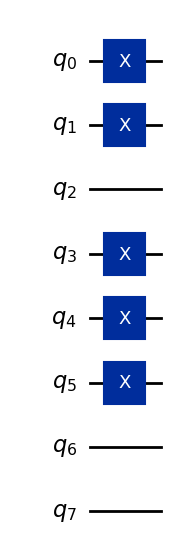

In [47]:
hf_state = HartreeFock(H2_problem.num_spatial_orbitals, H2_problem.num_particles, BravyiKitaevMapper())
hf_state.draw("mpl")

## Réductions de qubit plus avancées

Il est possible d'effectuer des réductions de qubit plus avancées, qui sont basées sur la recherche de symétries $\mathbb{Z}2$ dans l'espace de Hilbert du qubit. **Une exigence pour que cela soit utile est que vous sachiez dans quel sous-espace de symétrie vous devez rechercher votre solution d'intérêt réelle**. Cela peut être un peu délicat, mais heureusement, les classes de problèmes de Qiskit Nature vous fournissent un utilitaire pour déterminer automatiquement ce sous-espace correctement. 

Voici comment vous pouvez l'utiliser à votre avantage :

In [23]:
from qiskit_nature.second_q.mappers import TaperedQubitMapper

In [27]:
dmap = {"JWM": JordanWignerMapper(), "PM": ParityMapper(),  "BKM": BravyiKitaevMapper()}
for k, v in dmap.items():
    H2_z2qubit = H2_problem.get_tapered_mapper(v)
    H2_z2qubit = H2_z2qubit.map(H2_fermionic_op)

    print(f"Number of items in the {k} Z2 Pauli list:", len(H2_z2qubit))
#     print(H2_z2qubit)
    print()

Number of items in the JWM Z2 Pauli list: 122

Number of items in the PM Z2 Pauli list: 122

Number of items in the BKM Z2 Pauli list: 122



## Exercise

1. A fermionic Fock state is given by 
$$ |\Psi\rangle = a|0011\rangle + b|1100\rangle + c|1001\rangle + d|0110\rangle. $$

Write down the mapping onto the corresponding qubit state by using the **parity** and **Bravyi-Kitaev** transformations.

**Hint:** Use the article of Jacob T. Seeley, Martin J. Richard, and Peter J. Love, *The Bravyi-Kitaev transformation for quantum computation of electronic structure*, THE JOURNAL OF CHEMICAL PHYSICS 137, 224109 (2012).

2. Démontrer clairement, les résultats de l'équation (102) de l'article de Sam McArdle et *al.* *Quantum computational chemistry*, REVIEWS OF MODERN PHYSICS, VOLUME 92, JANUARY–MARCH 2020.
3. Ecrire un script qiskit permettant de retrouver les résultats de l'équation (102) de l'article de Sam McArdle et *al.* *Quantum computational chemistry*, REVIEWS OF MODERN PHYSICS, VOLUME 92, JANUARY–MARCH 2020.

## Questions

1. Which of the following terms is neglected in the BO approximation?

    A.	Electronic kinetic energy operator.

    B.	Nuclear kinetic energy operator.

    C.	Potential energy between the electrons and nuclei. It is the sum of all electron-nucleus Coulomb interactions.

    D.	Potential energy operator arising from electron-electron Coulomb repulsions.
    
2. The Slater determinant state function is antisymmetric with respect to: 

    A.	the exchange of two electrons (permutation of two rows) or, 

    B.	with respect to the exchange of two spin orbitals (permutation of two columns)

    C.	Or both the above?

3. Name three fermion to qubit transformations currently supported by Qiskit Nature.

4. Name two fermion to qubit transformations that simulates a system of electrons with the same number of qubits as electrons.

5.	For which transformation does the resulting Hamiltonian commute with the number spin up and number spin down operators which can be used to taper off two qubits?


In [25]:
# # %qiskit_version_table
# import tutorial_magics

# %qiskit_version_table